In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import geopy
from geopy.distance import vincenty
from pandas.plotting import scatter_matrix
import seaborn as sns

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from IPython.display import Image
from IPython.core.display import HTML
from IPython.display import HTML

from pylab import rcParams
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

init_notebook_mode(connected=True)

In [207]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" 
value="Click here to toggle on/off the raw code."></form>''')

# Does weather change riding habits in San Francisco?

Bike is fun and a green way to move around the city! I love to commute to work with my bike or go on a bike ride with my friends on a weekend.

Personally, I do own a bike. But there are so many reason why bike share is a good option.

I bike regularly be it rain or sunshine. Yet, when it's pooring, I would rather prefer to chose another type of transportation or stay inside instead of taking a bike trip to Sausalito.

With this analysis I will try to answer if weather impacts bike share habits and how. I will also try to predict bike share usage using weather as one of my features.

<img src="bikeme.png" width="400" height="50" align="center"/>

### Data

A weather data set is provided by NOAA
https://www.ncdc.noaa.gov/data-access/land-based-station-data and the bike-share data set is from Lyft: 
    https://www.lyft.com/bikes/bay-wheels/system-data.
The time period: from 2017-06-28 to 2018-05-23.

### Approach

I will start with data preprocessing: cleaning and merging the datasets. Then I'm going to analyze data and correlation between weather and bike share rides with EDA and correlation analysis. As a last step, I will invistigate if weather is a good predictor for bike share rides. 'm going to build a time series model to predict bike share rides based on historical data (SARIMA) and compare it with model which consideres weather (SARIMAX). 

** 🌦🚴🏻‍♀️🌁 STEPS:**
1. Data Preprocessing
2. Exploratory Data Analysis (EDA) and correlation analysis
3. Predicting Bike Share Usage with Time Series models (SARIMA and SARIMAX)
4. Summary and Next Steps

What is **not** in the scope of this project:
- __Wind:__ the weather data doesn't provide wind information which could also be a variable impacting bike shares.
- __Hourly weather:__ Since weather data file doesn't provide consistant hourly data, I will focus on daily weather measurement
- __Demographic factors__: I will not investigate on gender or age of the users to restrict the scope, but also since I'm interested in overall user behavior impacted by weather change.
- __Microclimates:__ we know that SF has microclimates, so generalizing SF weather data would be not less detailed approach but sufficient for this analysis.
- __Other confounding factors:__ The factors like holidays or events in the city etc. are definitly factors which impacts bike share usage, though they are not in the scope of this project

# 1. Data Preprocessing

In [3]:
wx = pd.read_csv('NOAA_SF_weather.csv')

### Preparing and cleaning Weather data

In [4]:
wx.head(2)

,DATE,HOURLYPrecip,HOURLYAltimeterSetting,DAILYMaximumDryBulbTemp,DAILYMinimumDryBulbTemp,DAILYAverageDryBulbTemp,DAILYDeptFromNormalAverageTemp,DAILYHeatingDegreeDays,DAILYCoolingDegreeDays,DAILYSunrise,DAILYSunset,DAILYPrecip
0,2017-01-01 19:59,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725,1703,NaN
1,2017-01-01 23:59,NaN,NaN,52.0,45.0,48.0,-2.6,17.0,0.0,725,1703,0.05


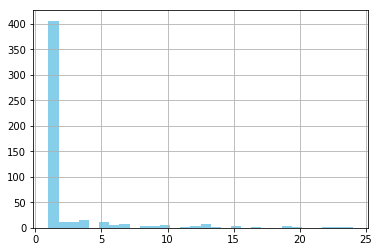

In [6]:
# Checking count of hourly data points
wx['DATE']= pd.to_datetime(wx['DATE'])
wx.DATE.groupby(wx['DATE'].dt.date).count().hist(bins=30, color='skyblue')

Most of the dates has only one row, meaning that we can not look at the hourly daily weather. Therefore, I will drop the columns and rows associated with hourly data.

In [7]:
# Dropping hourly columns:
wx.drop(columns=['HOURLYPrecip', 'HOURLYAltimeterSetting'], inplace=True)
# Dropping rows with hourly data (NA) and removing timestamp
wx.dropna(inplace=True)
wx['DATE'] = wx.DATE.dt.date
# Removing couple of other columns to narrow the scope
wx.drop(columns=['DAILYDeptFromNormalAverageTemp','DAILYHeatingDegreeDays','DAILYCoolingDegreeDays'], inplace=True)

In [8]:
# Adding daylight feature - duration in minutes of daytime
wx['daylight'] = wx['DAILYSunset'] - wx['DAILYSunrise']
# Adding difference between day's temprerature and previos day's temperature
wx['daily_temp_diff'] = wx['DAILYAverageDryBulbTemp'] - wx['DAILYAverageDryBulbTemp'].shift(1)
wx['daily_temp_diff'].fillna(0, inplace = True) 

In [9]:
# Renaming columns
wx.rename(columns= {'DATE': 'date', 'DAILYMaximumDryBulbTemp':'max_temp', 'DAILYMinimumDryBulbTemp': 'min_temp',
                   'DAILYAverageDryBulbTemp': 'avg_temp', 'DAILYSunrise': 'sunrise', 'DAILYSunset': 'sunset',
                   'DAILYPrecip': 'precip'}, inplace=True)

,date,max_temp,min_temp,avg_temp,sunrise,sunset,precip,daylight,daily_temp_diff
1,2017-01-01,52.0,45.0,48.0,725,1703,0.05,978,0.0
7,2017-01-02,51.0,43.0,47.0,726,1703,0.10,977,-1.0
27,2017-01-03,58.0,47.0,52.0,726,1704,0.40,978,5.0


In [12]:
# Checking the descriptive statistics. Nothing looks suspisious.
wx.describe()

,max_temp,min_temp,avg_temp,sunrise,sunset,precip,daylight,daily_temp_diff
count,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,64.236686,51.510848,57.850099,593.992110,1805.605523,0.080099,1211.613412,0.015779
std,7.638264,4.716611,5.835121,92.544637,88.756062,0.273002,177.892972,3.345067
min,50.000000,39.000000,45.000000,447.000000,1651.000000,0.000000,933.000000,-15.000000
25%,59.000000,49.000000,54.000000,518.000000,1728.000000,0.000000,1037.000000,-2.000000
50%,63.000000,52.000000,57.000000,607.000000,1818.000000,0.000000,1208.000000,0.000000
75%,67.000000,54.000000,61.000000,700.000000,1901.500000,0.000000,1385.000000,2.000000
max,106.000000,75.000000,89.000000,726.000000,1936.000000,3.150000,1487.000000,17.000000


In [17]:
wx.to_csv('wx.csv', index=False)

### Preparing and cleaning Bike Share data

I used the files for 2017 and 2018, which corresponds with my weather data.

In [19]:
# Combined all files into one csv:
all_bike_files = [i for i in glob.glob('*[0-9]*.*')]
combined_csv = pd.concat([pd.read_csv(f) for f in all_bike_files])
combined_csv.to_csv("bike_shares.csv", index=False, encoding='utf-8-sig')

In [25]:
bike = pd.read_csv('bike_shares.csv')

In [21]:
bike.head(2)

,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type
0,1035,No,598,114,37.764478,-122.402570,Rhode Island St at 17th St,2018-03-01 00:09:45.1870,1988.0,Male,284,37.784872,-122.400876,Yerba Buena Center for the Arts (Howard St at ...,2018-02-28 23:59:47.0970,Subscriber
1,1673,No,943,324,37.788300,-122.408531,Union Square (Powell St at Post St),2018-02-28 23:36:59.9740,1987.0,Male,6,37.804770,-122.403234,The Embarcadero at Sansome St,2018-02-28 23:21:16.4950,Customer


In [22]:
bike.shape

(1142896, 16)

In [26]:
# Adding date column
bike['date']= pd.to_datetime(bike['start_time']).dt.date
# Adding distance as a feature:
bike['distance'] = bike.apply(lambda x: geopy.distance.vincenty((x['start_station_latitude'], x['start_station_longitude']),
                                           (x['end_station_latitude'], x['end_station_longitude'])).miles, axis=1)
# Adding user_type as a dummy feature:
df_user = pd.get_dummies(bike['user_type'])
bike = pd.concat([bike, df_user], axis=1)

# Dropping columns:
bike.drop(columns=['bike_share_for_all_trip', 'end_station_id', 'end_station_latitude',
                  'end_station_longitude', 'end_station_name', 'end_time', 'start_station_id', 'start_station_latitude',
                  'start_station_longitude', 'start_station_name', 'member_birth_year', 'start_time', 'member_gender'], inplace=True)

In [29]:
cols = bike.columns.tolist()
cols = ['date', 'bike_id', 
    'duration_sec', 'distance', 'user_type', 'Customer', 'Subscriber']
bike = bike[cols]

In [31]:
# Checking missing values
bike.isnull().sum()

date            0
bike_id         0
duration_sec    0
distance        0
user_type       0
Customer        0
Subscriber      0
dtype: int64

In [32]:
bike.describe()

,bike_id,duration_sec,distance,Customer,Subscriber
count,1.142896e+06,1.142896e+06,1.142896e+06,1.142896e+06,1.142896e+06
mean,1.935029e+03,9.745475e+02,9.869804e-01,1.788448e-01,8.211552e-01
std,1.110299e+03,2.994466e+03,6.311052e-01,3.832225e-01,3.832225e-01
min,1.000000e+01,6.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.830000e+02,3.640000e+02,5.505641e-01,0.000000e+00,1.000000e+00
50%,2.003000e+03,5.710000e+02,8.603721e-01,0.000000e+00,1.000000e+00
75%,2.838000e+03,8.950000e+02,1.289513e+00,0.000000e+00,1.000000e+00
max,4.231000e+03,8.636900e+04,4.237529e+01,1.000000e+00,1.000000e+00


### Merging weather data on bike data

In [33]:
bike_wx = pd.merge(bike, wx, how='left', on='date')
# Dropping all dates we don't have temperature information
bike_wx.dropna(subset=['max_temp'], how='all', inplace = True)
bike_wx.to_csv('bike_wx.csv', index=False)

Additionally, I'm transforming the data to daily frequency for two reasons 1) the weather data set contains only daily data 2) it is more effiecient to model correlation and time series forecast on aggregated data.

In [35]:
# Aggregating bike data by date and creating features:
bike_gr = bike.groupby(by='date', as_index=False).agg({'bike_id': {'count_shares': 'count'}, 
                                             'duration_sec': {'avg_duration':'mean'},
                                            'distance': {'avg_distance': 'mean'},
                                            'Customer': {'count_customer': 'sum'},
                                            'Subscriber': {'count_subscriber': 'sum'}})

In [40]:
bt = pd.merge(bike_gr, wx, how='inner', on='date')
bt.shape

(329, 15)

In [41]:
# Drop some columns
bt.drop(columns=['date'], inplace=True)
cols = bt.columns.tolist()
cols = ['date', 'count_shares', 'avg_duration', 'avg_distance', 'count_customer', 'count_subscriber'] + cols[6:]
bt.columns = cols
bt.drop(columns=['sunrise', 'sunset'], inplace=True)

# Adding total duration
bt['total_dur'] = bt.avg_duration * bt.count_shares
cols = bt.columns.tolist()
cols = cols[0:4] +cols[-1:] + cols[4:-1]
bt = bt[cols]
bt.to_csv('bike_sharing_weather_daily.csv', index=False)

# <a name='eda'></a>EDA and correlation analysis

In [42]:
bt = pd.read_csv('bike_sharing_weather_daily.csv')
bike_wx = pd.read_csv('bike_wx.csv')

To understand the type of data we are dealing with I used histograms of each numerical attribute.

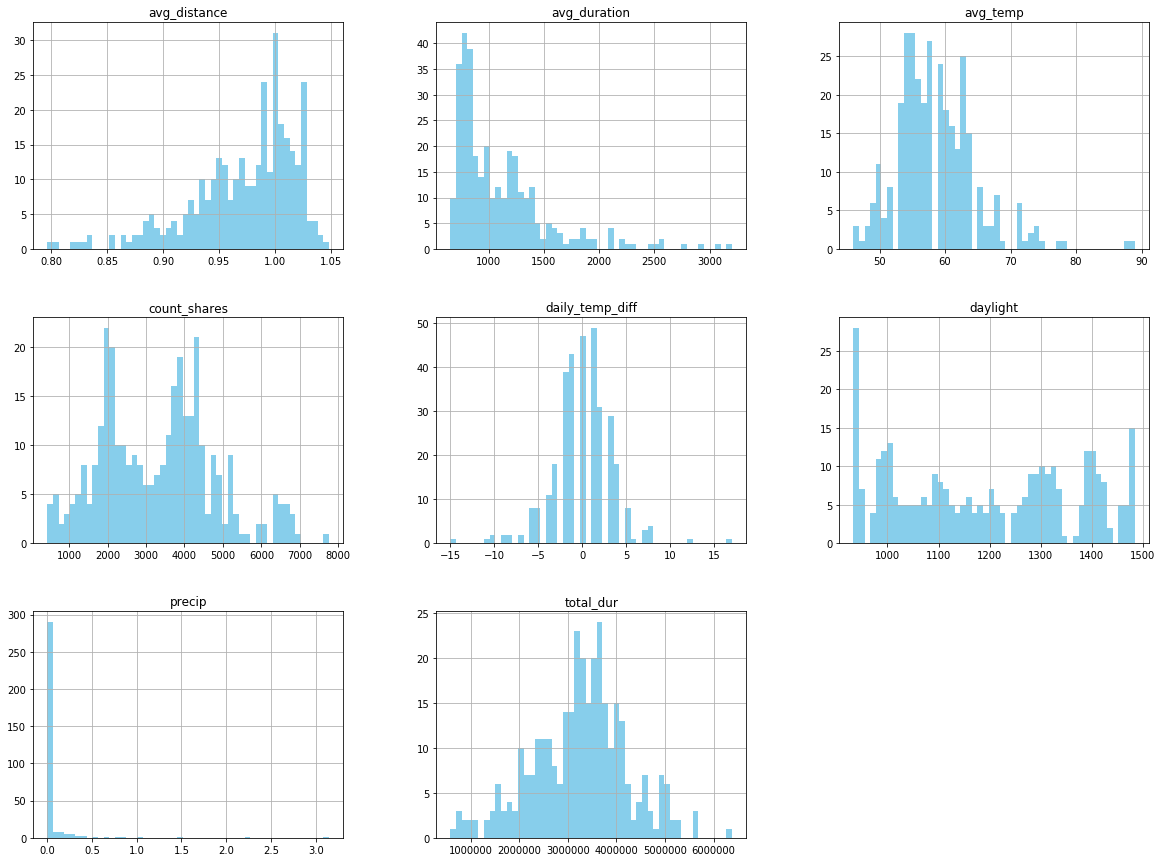

In [43]:
attr = ['avg_distance', 'avg_duration', 'total_dur', 'count_shares','avg_temp','daylight', 'daily_temp_diff', 'precip']
bt[attr].hist(bins=50, figsize=(20,15), color='skyblue')
plt.show()

In [44]:
no_rain = 1- list(bt[bt.precip > 0].count() / bt.count())[0]
no_rain

0.8358662613981763

A few things in these hisograms:
- Looking at the distribution of average temperature and precipation: most of the days the temperature is mild between 53 F and 64 F degrees with low amount of precipation. Indeed, there is no rain on 83.6% of days in the data set.
- Average duration of bike share is left skewed while the total duration seems to be more of a bell shape.
- There are some days with higher number of rides peaking at 2000 and 4000 probably due to an upward trend.

Next, I plotted and analyzed weather factors such as Temperature, Precipitation, Daylight, and their impact on bike-share rides as well as take a look on differences in the behavior of Subscribers vs. Customers in context of weather conditions.

### 🌤Temperature and ☔️ precipation

I categorized weather conditions splitting it into Cold (< 53F), Good (between 53F and 77F) and Hot (>77F).

In [45]:
def wx_feel(row):
    """Categorize the weather. The fuction might be very subjective 😉"""
    if row['avg_temp'] < 53:
        return 'cold'
    elif row['avg_temp'] >= 53 and row['avg_temp'] <= 77:
        return 'good' 
    else:
        return 'hot'

bike_wx['wx_feel'] = bike_wx.apply(wx_feel, axis=1)

In [213]:
bike_wx.to_csv('bike_wx.csv', index=False)

In [46]:
days = list(bike_wx.groupby('date').nunique().count())[0]
rain_ct = list(bike_wx[bike_wx.precip>0].groupby('wx_feel').bike_id.count()/days)
no_rain_ct= list(bike_wx[bike_wx.precip<=0].groupby('wx_feel').bike_id.count()/days)
#avg = bike_wx.bike_id.count()/ days

In [47]:
# Defining a color palette
light_blue = 'rgb(142, 212, 229)'
pink = 'rgb(231, 84, 128)'
green = 'rgb(199, 204, 118)'
grey = 'rgb(169,169,169)'
yellow = 'rgb(248, 222, 126)'

In [212]:
trace1 = go.Bar(
    x=['Cold & 🌧', 'Good & 🌧', 'Hot & 🌧'],
    y=rain_ct, marker = dict(color=light_blue),
    name='Rain')
trace2 = go.Bar(
    x=['Cold & 🌤', 'Good & 🌤', 'Hot & 🌤'],
    y=no_rain_ct,
    name='No Rain', marker = dict(color=yellow))

# trace3 = go.Scatter(
#     x=['Cold & 🌧', 'Good & 🌧','Cold & 🌤', 'Good & 🌤', 'Hot & 🌤'],
#     y=[avg]*5,
#     name='Overall average', marker = dict(color=pink))

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack', title = 'Daily average number of bike share rides by weather and precipation', xaxis=dict(title='Weather condition'),
    yaxis=dict(
        title='Average number of bike share rides'),)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename = "Weather")

Looking at the average number of bike-share rides by condition we can conclude that people use bike-share more often when the weather is good.

### Now let's take a look how weather impacts bike ride duration.

In [49]:
rain_avg_dur = list(bike_wx[bike_wx.precip>0].groupby('wx_feel').duration_sec.mean()/60)
no_rain_avg_dur = list(bike_wx[bike_wx.precip<=0].groupby('wx_feel').duration_sec.mean()/60)

In [217]:
(np.mean(np.array(no_rain_avg_dur)) - np.mean(np.array(rain_avg_dur)))/np.mean(np.array(rain_avg_dur))

0.20785644805127576

In [50]:
trace1 = go.Bar(
    x=['Cold & 🌧', 'Good & 🌧', 'Hot & 🌧'],
    y=rain_avg_dur, marker = dict(color=light_blue),
    name='Rain')
trace2 = go.Bar(
    x=['Cold & 🌤', 'Good & 🌤', 'Hot & 🌤'],
    y=no_rain_avg_dur,
    name='No Rain', marker = dict(color=yellow))

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack', title = 'Average duration of a bike share ride (in minutes) by weather and precipation', xaxis=dict(title='Weather condition'),
    yaxis=dict(
        title='Average duration of a bike share ride'),)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename = "Weather")

Temperature change during rainy does not impact ride duration; on the other hand, hot days with no rain have longer rides.

### 🥵 Temperature variability

For temperature variability I'm analyzing the weekly changes (weekends included).

In [51]:
dates = [i[0] for i in bike_wx.groupby('date')]
dates_w = dates[5:]
dates_w = [dates_w[i] for i in range(0, len(dates_w), 7)]
weekly = bt[bt['date'].isin(dates_w)]

In [52]:
temp_diff = list((weekly.avg_temp-weekly.avg_temp.shift(1))/ weekly.avg_temp.shift(1))[1:]
rides_diff = list((weekly.count_shares-weekly.count_shares.shift(1))/ weekly.count_shares.shift(1))[1:]
avg_dur_diff = list((weekly.avg_duration-weekly.avg_duration.shift(1))/ weekly.avg_duration.shift(1))[1:]

In [218]:
trace1 = go.Scatter(x=dates_w[1:],
        y=temp_diff, name='Delta in temperature', marker = dict(color=pink))

trace2 = go.Bar(
        x=dates_w[1:],
        y=rides_diff, name='Number of rides', marker = dict(color=yellow))
trace3 = go.Bar(
        x=dates_w[1:],
        y=avg_dur_diff, name='Average ride duration', marker = dict(color=light_blue))

data = [trace1, trace2, trace3]

layout = go.Layout(legend=dict(x=1.1, y=1), title = 'Impact of temperature drop/rise on increase/decrease in Bike Share rides',
xaxis=dict(title='Time'), yaxis=dict(title='in %', titlefont=dict(),tickfont=dict()))
 
fig = go.Figure(data=data, layout=layout) 
iplot(fig, filename = "Weather")

This data is not very helpful. You can see that in most of the cases the number of rides and average ride duration follows the weather variability pattern. But there is also some other factors like the pick of average rode duration is on December 25th (right after Christmas).

### 🌝 Daylight

I can assume that when it's getting dark early then people bike less, let's take a look.

In [54]:
daylight = [i[0] for i in bike_wx.groupby('date').agg({'daylight':'mean'}).values]
rides = [i[0] for i in bike_wx.groupby('date').agg({'bike_id':'count'}).values]
avg_dur = [i[0] for i in bike_wx.groupby('date').agg({'duration_sec':'mean'}).values]
dates = [i[0] for i in bike_wx.groupby('date')]

In [55]:
trace1 = go.Scatter(x=dates, y=daylight, name="Daylight", marker = dict(color=pink))
trace2 = go.Scatter(x=dates, y=rides, name="Number of rides", marker = dict(color=yellow))
trace3 = go.Scatter(x=dates, y=avg_dur, name="Average ride duration", marker = dict(color=light_blue))

data = [trace1, trace2, trace3]
layout = go.Layout(legend=dict(x=1.1, y=1), title = 'Impact of daylight duration on Number of rides and Average ride duration',
xaxis=dict(title='Time'), yaxis=dict(title='Individual Measurements of Each Factor*', titlefont=dict(),tickfont=dict()))
    
fig = go.Figure(data=data, layout=layout) 
iplot(fig, filename = "Weather")

<br>\*Daylight: time in minutes
<br>\*Numer of rides: count of rides
<br>\*Average ride duration: time in sec

We can clearly see that daylight duration is low in winter and the pattern of Number of rides and Average ride duration follows this trend. Another interesting observation is that both average ride duratiion and number of rides increases on weekends.

### 💰 Subsciber vs. Customer

Let's think about the monetazation of bike share.
The current Bay Wheels' business model is as follows:
- Customers pay \$2 for one ride up to 30 minutes and \$3 for every additional 15 minutes.
- Subscribers have 45 minutes free unlimited rides and pay \$3 for ever additional 15 minutes. The monthly subscribtion is about \$15 a month.

So, based on that, we can assume that the longer the rides the more revenue company has.
That's why I'm going to compare Subscribers' vs. Customers' ride duration.

In [56]:
# 2700 sec is 45 min 
sub_long_rain = bike_wx[(bike_wx.duration_sec > 2700) & (bike_wx.user_type == 'Subscriber')&\
                        (bike_wx.precip > 0)].bike_id.count() / bike_wx[(bike_wx.user_type == 'Subscriber')]\
                        .bike_id.count()
sub_short_rain = bike_wx[(bike_wx.duration_sec <= 2700) & (bike_wx.user_type == 'Subscriber')&\
                        (bike_wx.precip > 0)].bike_id.count() / bike_wx[(bike_wx.user_type == 'Subscriber')]\
                        .bike_id.count()
sub_long_norain = bike_wx[(bike_wx.duration_sec > 2700) & (bike_wx.user_type == 'Subscriber')&\
                        (bike_wx.precip <= 0)].bike_id.count() / bike_wx[(bike_wx.user_type == 'Subscriber')]\
                        .bike_id.count()
sub_short_norain = bike_wx[(bike_wx.duration_sec <= 2700) & (bike_wx.user_type == 'Subscriber')&\
                        (bike_wx.precip <= 0)].bike_id.count() / bike_wx[(bike_wx.user_type == 'Subscriber')]\
                        .bike_id.count()

cus_long_rain = bike_wx[(bike_wx.duration_sec > 2700) & (bike_wx.user_type == 'Customer')&\
                        (bike_wx.precip > 0)].bike_id.count() / bike_wx[(bike_wx.user_type == 'Customer')]\
                        .bike_id.count()
cus_short_rain = bike_wx[(bike_wx.duration_sec <= 2700) & (bike_wx.user_type == 'Customer')&\
                        (bike_wx.precip > 0)].bike_id.count() / bike_wx[(bike_wx.user_type == 'Customer')]\
                        .bike_id.count()    
cus_long_norain = bike_wx[(bike_wx.duration_sec > 2700) & (bike_wx.user_type == 'Customer')&\
                        (bike_wx.precip <= 0)].bike_id.count() / bike_wx[(bike_wx.user_type == 'Customer')]\
                        .bike_id.count()
cus_short_norain = bike_wx[(bike_wx.duration_sec <= 2700) & (bike_wx.user_type == 'Customer')&\
                        (bike_wx.precip <= 0)].bike_id.count() / bike_wx[(bike_wx.user_type == 'Customer')]\
                        .bike_id.count()    

In [57]:
trace1 = go.Bar(
    x=['Subscriber <= 45min', 'Subscriber > 45min', 'Customer <= 45min', 'Customer > 45min'],
    y=[sub_short_rain, sub_long_rain, cus_short_rain, cus_long_rain], marker = dict(color=light_blue),
    name='Rain')
trace2 = go.Bar(
    x=['Subscriber <= 45min', 'Subscriber > 45min', 'Customer <= 45min', 'Customer > 45min'],
    y=[sub_short_norain, sub_long_norain, cus_short_norain, cus_long_norain],
    name='NoRain', marker = dict(color=yellow))

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack', title = '% of bike share rides for subscribers vs customers by weather', 
    xaxis=dict(title='Subscriber vs. Customer'),
    yaxis=dict(
        title='% of ride number'),)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename = "Bike Shares")

In [58]:
sub_long_rain = bike_wx[(bike_wx.duration_sec > 2700) & (bike_wx.user_type == 'Subscriber')&\
                        (bike_wx.precip > 0)].duration_sec.mean()/60

sub_short_rain = bike_wx[(bike_wx.duration_sec <= 2700) & (bike_wx.user_type == 'Subscriber')&\
                        (bike_wx.precip > 0)].duration_sec.mean()/60

sub_long_norain = bike_wx[(bike_wx.duration_sec > 2700) & (bike_wx.user_type == 'Subscriber')&\
                        (bike_wx.precip <= 0)].duration_sec.mean()/60

sub_short_norain = bike_wx[(bike_wx.duration_sec <= 2700) & (bike_wx.user_type == 'Subscriber')&\
                        (bike_wx.precip <= 0)].duration_sec.mean()/60

cus_long_rain = bike_wx[(bike_wx.duration_sec > 2700) & (bike_wx.user_type == 'Customer')&\
                        (bike_wx.precip > 0)].duration_sec.mean()/60
cus_short_rain = bike_wx[(bike_wx.duration_sec <= 2700) & (bike_wx.user_type == 'Customer')&\
                        (bike_wx.precip > 0)].duration_sec.mean()/60
cus_long_norain = bike_wx[(bike_wx.duration_sec > 2700) & (bike_wx.user_type == 'Customer')&\
                        (bike_wx.precip <= 0)].duration_sec.mean()/60
cus_short_norain = bike_wx[(bike_wx.duration_sec <= 2700) & (bike_wx.user_type == 'Customer')&\
                        (bike_wx.precip <= 0)].duration_sec.mean()/60

In [59]:
trace1 = go.Bar(
    x=['Subscriber <= 45min', 'Subscriber > 45min', 'Customer <= 45min', 'Customer > 45min'],
    y=[sub_short_rain, sub_long_rain, cus_short_rain, cus_long_rain], marker = dict(color=light_blue),
    name='Rain')
trace2 = go.Bar(
    x=['Subscriber <= 45min', 'Subscriber > 45min', 'Customer <= 45min', 'Customer > 45min'],
    y=[sub_short_norain, sub_long_norain, cus_short_norain, cus_long_norain],
    name='No Rain', marker = dict(color=yellow))

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack', title = 'Comparing subscribers vs. customers behaviour by weather and length of a ride', 
    xaxis=dict(title='Subscriber vs. Customer'),
    yaxis=dict(
        title='Average duration'),)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename = "Bike Shares")

It seems that there is no big difference between Subscriber and Customer with regards to weather/precipation. Looks like Subscriber mostly takes shorter rides which is included in their subscribtion, which makes sense.

In [68]:
bt['wx_feel'] = bt['wx_feel'] = bt.apply(wx_feel, axis=1)

In [219]:
bt.to_csv('bike_sharing_weather_daily.csv', index=False)

In [69]:
# Good
cust_g = bt[bt.wx_feel == 'good'].count_customer.sum() / bt[bt.wx_feel == 'good'].count_shares.sum()
sub_g = bt[bt.wx_feel == 'good'].count_subscriber.sum() / bt[bt.wx_feel == 'good'].count_shares.sum()
# Cold
cust_c = bt[bt.wx_feel == 'cold'].count_customer.sum() / bt[bt.wx_feel == 'cold'].count_shares.sum()
sub_c = bt[bt.wx_feel == 'cold'].count_subscriber.sum() / bt[bt.wx_feel == 'cold'].count_shares.sum()
# Hot
cust_h = bt[bt.wx_feel == 'hot'].count_customer.sum() / bt[bt.wx_feel == 'hot'].count_shares.sum()
sub_h = bt[bt.wx_feel == 'hot'].count_subscriber.sum() / bt[bt.wx_feel == 'hot'].count_shares.sum()

In [72]:
trace1 = go.Bar(
    x=['Cold', 'Good', 'Hot'],
    y=[cust_c, cust_g, cust_h], marker = dict(color=grey),
    name='Customer')
trace2 = go.Bar(
    x=['Cold', 'Good', 'Hot'],
    y=[sub_c, sub_g, sub_h],
    name='Subscriber', marker = dict(color=pink))

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack', title = 'Comparing customers vs. subscribers behaviour by weather', 
    xaxis=dict(title='Weather condition'),
    yaxis=dict(
        title='% of total bike share rides'),)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename = "Bike Shares")

Seems like proportionally more customers use bike share when weather is good or hot.

## Exploring correlations

I'm computing Pearson's correlations between every pair.

In [73]:
corr_matrix = bt.corr()
corr_matrix['count_shares'].sort_values(ascending=False)

count_shares        1.000000
count_subscriber    0.984358
total_dur           0.784564
avg_distance        0.702357
count_customer      0.184132
daily_temp_diff     0.064711
daylight            0.016215
max_temp           -0.008565
avg_temp           -0.032397
min_temp           -0.064643
precip             -0.133744
avg_duration       -0.663384
Name: count_shares, dtype: float64

It seems that the correlaton between weather and count is very low. The highest for weather feature is a negative correlation with precipation. Let's check average duration and total duration.

In [74]:
corr_matrix['avg_duration'].sort_values(ascending=False)

avg_duration        1.000000
count_customer      0.335382
daylight            0.274030
avg_temp            0.265020
min_temp            0.252748
max_temp            0.251981
daily_temp_diff     0.014498
precip             -0.157170
total_dur          -0.177723
avg_distance       -0.616032
count_shares       -0.663384
count_subscriber   -0.735017
Name: avg_duration, dtype: float64

The correlation for duration of the ride is much higher compared to number of bike rides. That means that the number of bike share a day is not as impacted by weather as much as the duration of the ride. My conclusion here is that if it's a rainy or cold day, people avoid long bike rides.

To vizualize the correlation, I'm plotting pandas scatter_matrix.

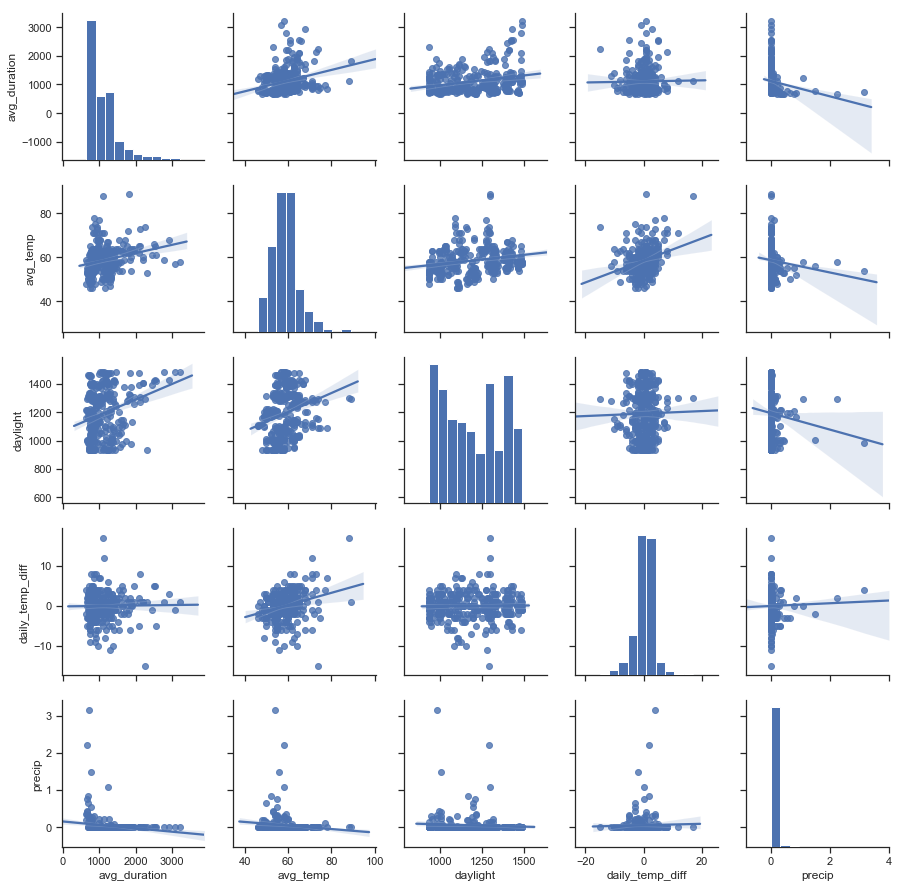

In [78]:
attr = ['avg_duration','avg_temp', 'daylight', 'daily_temp_diff', 'precip']
sns.set(style="ticks", color_codes=True)
sns.pairplot(bt[attr], kind="reg")
plt.show()

# Predicting daily bike share rides with time series (SARIMA and SARIMAX)

I detected some correlation between weather and bike share count and duration, with time series models I'm going to check if weather is good predictors of daily bike share rides.

I will construct a SARIMA and a SARIMAX model and compare their results to find out if weather improves prediction accuracy. I will focus below on predicting the number of bike share rides per day, but similar models could be applied  to predict daily duration of the bike share trips. Both metrics are important for bike share business. The number of rides prediction can be used for planning the capacity. The duration would be helpful to forecast company's revenue.

Let's plot time series of daily number of bike share rides over one year period of time:

Text(0.5,1,'Time Series of bike share rides by day')

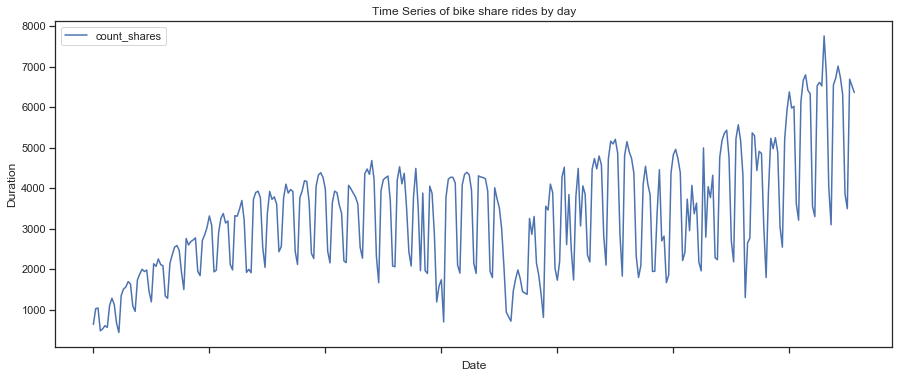

In [81]:
bt.plot(x='date', y='count_shares', figsize=(15,6))
plt.xlabel('Date')
plt.ylabel('Duration')
plt.title('Time Series of bike share rides by day')

The time-series has seasonality pattern: the rides goes down in winter time and seems like there are peaks during weekends. There is also an upward trend.

I'm going to decompose the data to see: trend, seasonality, and noise.

In [83]:
bt_ts = bt.iloc[:, [0, 1, 10]].set_index('date')

In [85]:
# Selection 7 for weekly seasonality decomposition:
decomposed = sm.tsa.seasonal_decompose(bt_ts.count_shares, freq=7)

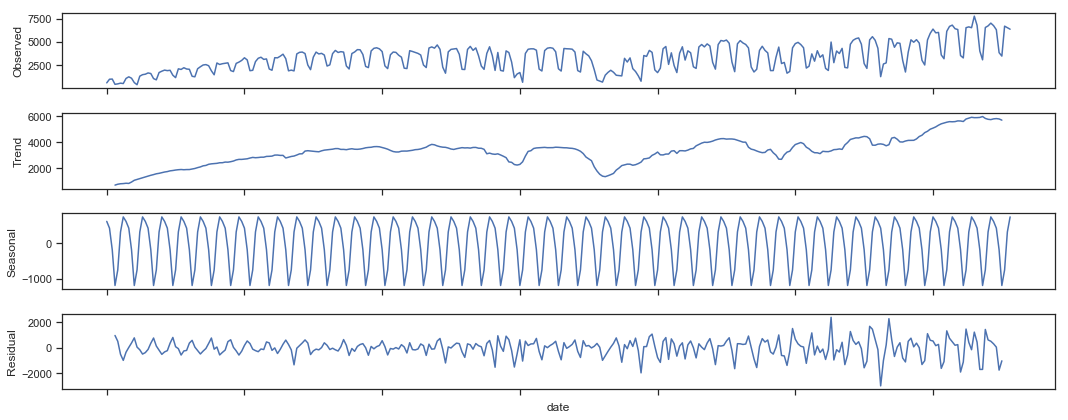

In [86]:
rcParams['figure.figsize'] = 15, 6
decomposed.plot()
plt.show()

With the frequency of 7 days, we see that there is a seasonality pattern in the data. The upward trend is also very prominent.

I'm going to apply one of the common method for time series modeling, SARIMA stands for Seasonal Autoregressive Integrated Moving Average.
SARIMA model has following orders/parameters (p, d, q)
* p - parameter for AR portion and incorporates past values
* d - is integrated part of the model, which shows the amount of differencing applied to the model
* q - parameter of MA of the model.

As we have seasonal ARIMA, there will be another set of parameters notated as (P,D,Q) which describes the same association as p, d, q but correspond with seasonal component of the model.
The goal is to select optimal orders. It could be done via likelihood ratio test or comparison of goodness-of-fit metrics. I will use iterative method and compare goodness-of-fit.
Before doing that, I'm going to test stationarity of the data since we need the time series to be stationary (having no trend).
I will use ADF test (Augmented-Dickey Fuller test).

In [105]:
def adf_test(data):
    """Augmented Dickey Fuller Test for stationarity and prints test
    statistics as well as plots the data with rolling mean and 
    standard deviation"""
    
    rmean = data.rolling(window=7, center=False).mean()
    rstd = data.rolling(window=7, center=False).std()
    
    fig = plt.figure(figsize=(15, 6))
    orig = plt.plot(data, color='steelblue',label='Bike share rides', alpha=.7)
    mean = plt.plot(rmean, color='deeppink', label='Rolling Mean', alpha=.7)
    std = plt.plot(rstd, color='darkgrey', label = 'Rolling Std')
    labels = []*len(bt_ts)
    plt.xticks(labels, labels)
    plt.legend(loc='best')
    plt.show()
    
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

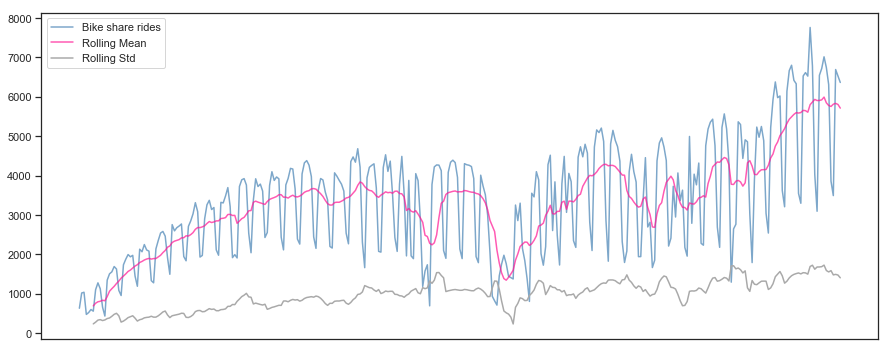

ADF Statistic: -1.652658
p-value: 0.455655
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


In [106]:
adf_test(bt_ts.count_shares)

Based on p-value, we fail to reject the null hypothesis of stationarity of the data and conclude that time series is not stationary. I will need to apply differencing.

In [107]:
# Difference the time series with lag=1
bt_ts1 = bt_ts.diff(1).iloc[1::]

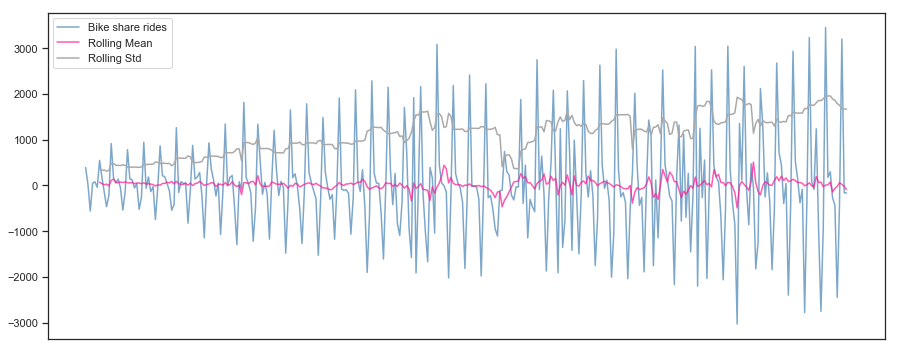

ADF Statistic: -5.247460
p-value: 0.000007
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


In [108]:
adf_test(bt_ts1.iloc[:,0])

Great, p-value is smaller than alpha = 0.05, thus I conclude, the differenced times series is stationary. I will use d=1 for my SARIMA model.

With the following test I'm going to determine parameters using interative method and goodness-of-fit AIC - Akaike information criterion, an estimator of the relative quality of statistical models.

In [109]:
def best_param(data):
    """Finding best parameters for SARIMA model. Iterative method based on comparison of
    goodness-of-fit metric AIC"""
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    PDQ = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
    params_d = {}
    for i in pdq:
        for j in PDQ:

                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=i,
                                                seasonal_order=j,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
                results = mod.fit()
                params_d[(i, j)] = results.aic
        
    return print(f'SARIMA: {min(params_d, key=params_d.get)[0]}x{min(params_d, key=params_d.get)[1]}')

In [110]:
best_param(bt_ts.count_shares)

SARIMA: (1, 1, 1)x(1, 1, 1, 7)


## SARIMA model

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.2514      0.074      3.387      0.001       0.106       0.397
ma.S.L7       -0.7503      0.056    -13.310      0.000      -0.861      -0.640
sigma2      5.358e+05   2.75e+04     19.501      0.000    4.82e+05     5.9e+05


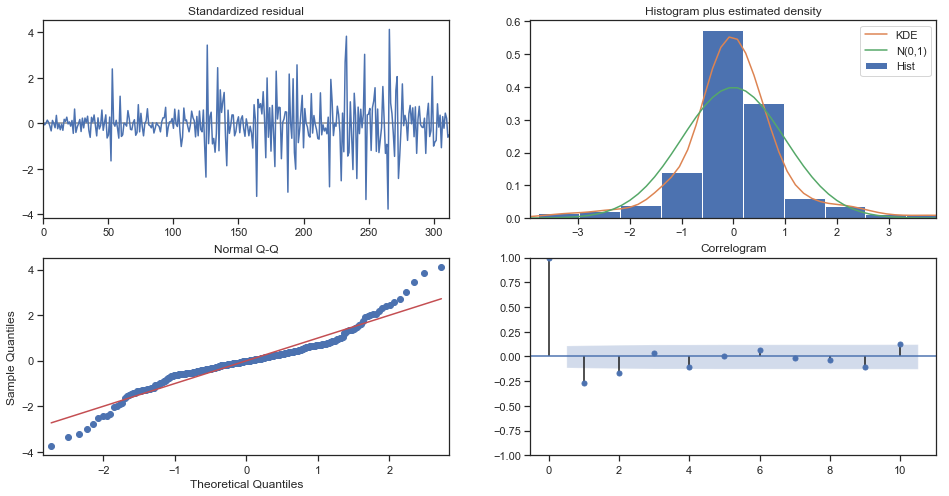

In [111]:
# I will slightly deviate from the aboove test result and select 0 for both p and q for simplicity reason.
model_1 = sm.tsa.statespace.SARIMAX(bt_ts.count_shares,
                                order=(0, 1, 0),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
print(model_1.fit().summary().tables[1])

# Diagnostoc to check if there is anything unusual
model_1.fit().plot_diagnostics(figsize=(16, 8))
plt.show()

It not ideal, but the diagnostic suggests that the residuals are distibuted almost normally.

## SARIMAX model

Since we have data on weather variables collected for the same frequency as the response series and these weather data as explored above is correlated with the respinse we may exploit that relationship by ising multivariate time series model. 
Weather influences the bike share rides, but not the other way round, that means that the weather is an exogenous factor thus I will be using SARIMAX (X - stands for exogenous).

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
precip     -1061.7135     49.792    -21.323      0.000   -1159.304    -964.123
ar.S.L7       -0.0055      0.078     -0.071      0.944      -0.159       0.148
ma.S.L7       -0.5631      0.060     -9.439      0.000      -0.680      -0.446
sigma2      3.988e+05   1.98e+04     20.143      0.000     3.6e+05    4.38e+05


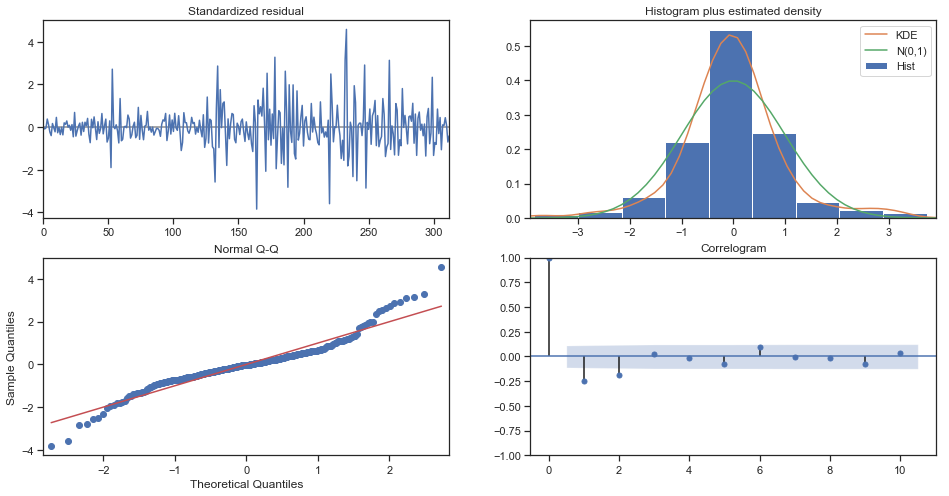

In [112]:
model_2 = sm.tsa.statespace.SARIMAX(bt_ts.count_shares,
                                order=(0, 1, 0),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                               exog=bt_ts.precip)
print(model_2.fit().summary().tables[1])
model_2.fit().plot_diagnostics(figsize=(16, 8))
plt.show()

## Evaluating models

Now let's test these models in turms of their predictive power and compare performance metric RMSE.
<br> First, I'm going to train test split the data. Since it's a time series model I will cut off a latest portion of the data for test purposes.

In [113]:
print(f'I will set a side 10% of the data: {round(bt_ts.shape[0]*0.1)} samples')

I will set a side 10% of the data: 33 samples


In [114]:
train = bt_ts['2017-06-28':'2018-04-20']
test = bt_ts['2018-04-21':]

In [115]:
result_1 = model_1.fit(train.count_shares)

In [203]:
# I'm showing here the last 3 months roughtly for better visualization:
pred_1 = result_1.get_prediction(start='2018-04-21', dynamic=False)
pred_ci = pred_1.conf_int()

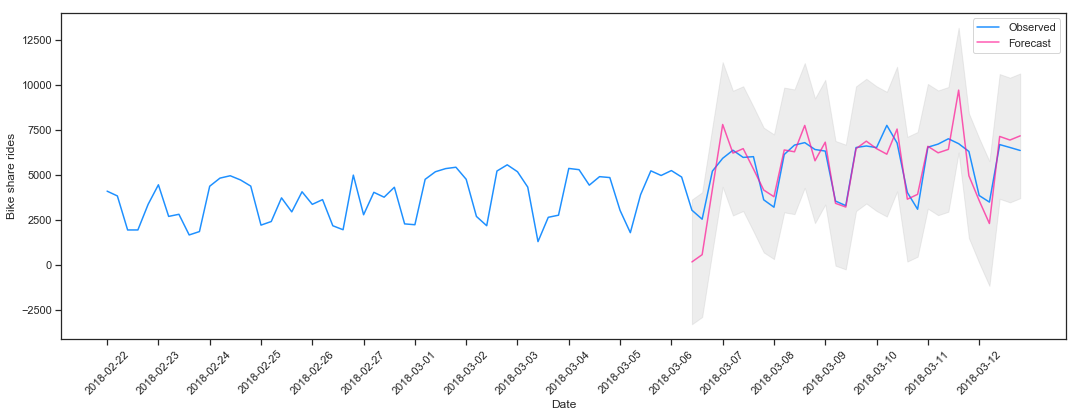

In [204]:
pred = pred_1.predicted_mean.to_frame()
pred_plus_ci = pd.merge(pred_ci, pred, how='left', on='date')
pred_plus_ci.rename(columns={0: 'pred'}, inplace=True)

tr = bt_ts.iloc[-90:,0].to_frame()
pred_to_plot = pd.merge(tr, pred_plus_ci, how='left', on='date')

ax = pred_to_plot.count_shares.plot(label='Observed', color='dodgerblue')
pred_to_plot.pred.plot(ax=ax, label='Forecast', alpha=.7, figsize=(18, 6), color='deeppink')

ax.fill_between(pred_to_plot.index,
                pred_to_plot.iloc[:, 1],
                pred_to_plot.iloc[:, 2], color='darkgrey', alpha=.2)

xticks = pred_to_plot.index
ax.xaxis.set_ticks(xticks)
ax.set_xticklabels(xticks, alpha=1, rotation=45)
ax.set_xticks(ax.get_xticks()[::5])

ax.set_xlabel('Date')
ax.set_ylabel('Bike share rides')
plt.legend()
plt.show()

In [119]:
print('Results of SARIMA:')
print('------------------')
mse = mean_squared_error(test.count_shares, pred_1.predicted_mean)
print('The RMSE of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
r2 = r2_score(test.count_shares, pred_1.predicted_mean)
print('The R2 of our forecasts is {}'.format(round(r2,2)))

Results of SARIMA:
------------------
The RMSE of our forecasts is 1069.76
The R2 of our forecasts is 0.49


Let's fit and evaluate SARIMAX model.

In [121]:
result_2 = model_2.fit(train.count_shares)

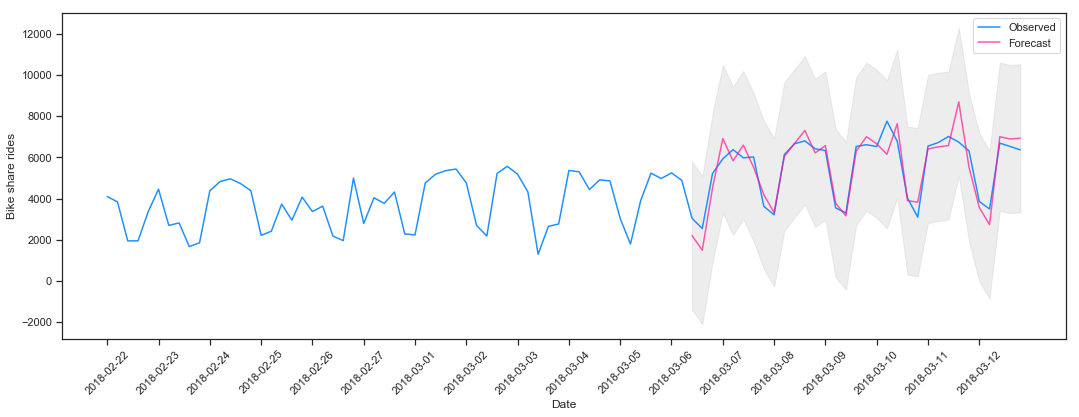

In [205]:
# I'm showing here the last 3 months roughtly for better visualization:
pred_2 = result_2.get_prediction(start='2018-04-21', dynamic=False)
pred_ci = pred_2.conf_int()

pred = pred_2.predicted_mean.to_frame()
pred_plus_ci = pd.merge(pred_ci, pred, how='left', on='date')
pred_plus_ci.rename(columns={0: 'pred'}, inplace=True)

tr = bt_ts.iloc[-90:,0].to_frame()
pred_to_plot = pd.merge(tr, pred_plus_ci, how='left', on='date')

ax = pred_to_plot.count_shares.plot(label='Observed', color='dodgerblue')
pred_to_plot.pred.plot(ax=ax, label='Forecast', alpha=.7, figsize=(18, 6), color='deeppink')

ax.fill_between(pred_to_plot.index,
                pred_to_plot.iloc[:, 1],
                pred_to_plot.iloc[:, 2], color='darkgrey', alpha=.2)

xticks = pred_to_plot.index
ax.xaxis.set_ticks(xticks)
ax.set_xticklabels(xticks, alpha=1, rotation=45)
ax.set_xticks(ax.get_xticks()[::5])

ax.set_xlabel('Date')
ax.set_ylabel('Bike share rides')
plt.legend()
plt.show()

In [206]:
print('Results of SARIMAX:')
print('-------------------')
mse = mean_squared_error(test.count_shares, pred_2.predicted_mean)
print('The RMSE of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
r2 = r2_score(test.count_shares, pred_2.predicted_mean)
print('The R2 of our forecasts is {}'.format(round(r2,2)))

Results of SARIMAX:
-------------------
The RMSE of our forecasts is 673.52
The R2 of our forecasts is 0.8


☀️Great, we reduced our RMSE and increased R2, that shows us that including weather features for our forcast improves predictions.

# Findings and Next Steps

👉 Weather change does impact bike share behavior, we saw that from EDA on the data, correlation analysis as well as on time series forecasting. Including weather features improves predictions vs. usage of only historical data.
<br>👉 We could further improve our SARIMAX model by 1) tuning the hyperparameters 2) adding more exogenous features e.g. temperature or difference between daily temperature.
<br>👉 We could try more advanced techniques for modeling e.g. Random Forest Regressor or Neural Network models (LSTM, RNN)
<br>👉 Another possibility would be to consider hourly bike rides forecast with respective hourly weather data.

[TO BLA BLA SEE HOW I DID IT](http://localhost:8888/notebooks/Bike_Share_WX_Impact/Bike%20Share%20and%20Weather.ipynb)